# Analysis Processed Slocum Glider-AD2CP Data: RU29 2021 Mission 2

In [2]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [3]:
ds_id = 'ru29-20210908T1943-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.0,18.172288,-64.968623,2021-09-08T19:43:16.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
1,NaN,18.172288,-64.968623,2021-09-08T19:43:22.01Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
2,0.0,18.172288,-64.968623,2021-09-08T19:43:23.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
3,NaN,18.172288,-64.968623,2021-09-08T19:44:26.30Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
4,NaN,18.172270,-64.968681,2021-09-08T19:44:52.37Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1453164,NaN,NaN,NaN,2021-10-07T19:57:17.47Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453165,NaN,NaN,NaN,2021-10-07T19:57:23.31Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453166,NaN,NaN,NaN,2021-10-07T19:57:30.35Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453167,NaN,NaN,NaN,2021-10-07T19:57:34.80Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN


## Step 2: Load processed AD2CP data

In [4]:
path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Processed/"
files = np.sort(glob.glob(path+'*.csv'))

df = pd.concat(map(pd.read_csv, files))

df

,Unnamed: 0,inversion_u,inversion_v,inversion_depth,longitude,latitude,start_tm,end_tm
0,0,-2.409334,0.916772,5.0,-64.969161,18.171524,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
1,1,-2.423587,0.908325,15.0,-64.969161,18.171524,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
2,2,-2.456976,1.011689,25.0,-64.969161,18.171524,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
3,3,-2.422848,1.034870,35.0,-64.969161,18.171524,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
4,4,-2.383238,1.048278,45.0,-64.969161,18.171524,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
...,...,...,...,...,...,...,...,...
77,77,-0.022965,0.062201,775.0,-63.255579,18.036397,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z
78,78,-0.019986,0.073740,785.0,-63.255579,18.036397,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z
79,79,-0.011812,0.074078,795.0,-63.255579,18.036397,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z
80,80,-0.008803,0.071295,805.0,-63.255579,18.036397,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z


In [5]:
inversion_depth   = np.arange(5,1030,10)
inversion_lat    = np.empty(len(files))
inversion_lat[:] = np.NaN
inversion_lon    = np.empty(len(files))
inversion_lon[:] = np.NaN
inversion_time    = np.empty(len(files))
inversion_time[:] = np.NaN

u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file


for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    inversion_lat[x] = df.latitude.values[0]
    inversion_lon[x] = df.longitude.values[0]
    #inversion_time[x] = pd.to_datetime(df.start_tm.values[0])
     

Text(0.5, 1.0, 'RU29 2021 Anegada Mission 2')

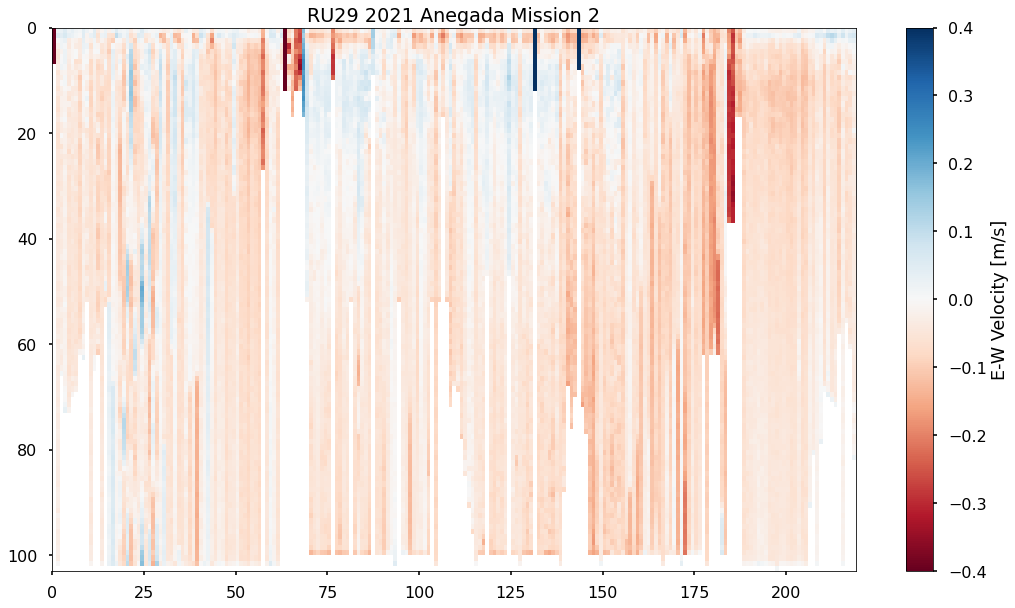

In [6]:
plt.figure(figsize=(18,10))
plt.pcolormesh(u_grid,cmap='RdBu',vmin=-0.4,vmax=0.4)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 2')